In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
from collections import Counter
import numpy as np
from torchvision import datasets

In [3]:
data_dir = r'C:\Users\Qaiaty store\Desktop\Project.github.io-main\EuroSAT'  # <- Edit this to match your local path



transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize to [-1, 1]
])

from torch.utils.data import Subset

full_dataset = ImageFolder(root=data_dir, transform=transform)
subset_indices = list(range(0, len(full_dataset),10))  # load every 10th image only
dataset = Subset(full_dataset, subset_indices)
class_names = full_dataset.classes  # ✔️ access from the original full dataset
print(f"Total images: {len(full_dataset)}")
print(f"Classes: {class_names}")


Total images: 27000
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Counter({0: 3000, 1: 3000, 2: 3000, 7: 3000, 9: 3000, 3: 2500, 4: 2500, 6: 2500, 8: 2500, 5: 2000})


C:\Users\Qaiaty store\AppData\Local\Temp\ipykernel_8872\2080428592.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()),palette="rocket")


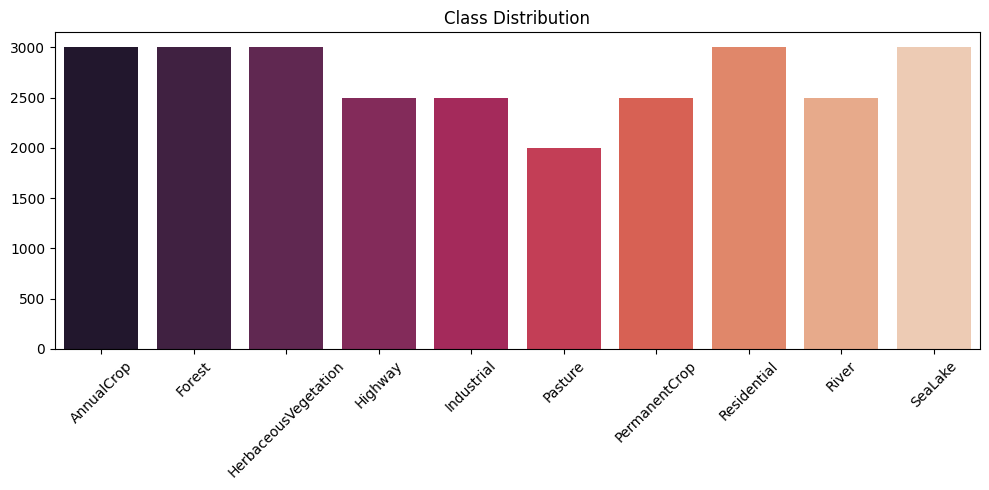

In [4]:
labels = full_dataset.targets
label_counts = Counter(labels)
print(label_counts)
plt.figure(figsize=(10, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()),palette="rocket")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('barplot_milestone1')
plt.show()

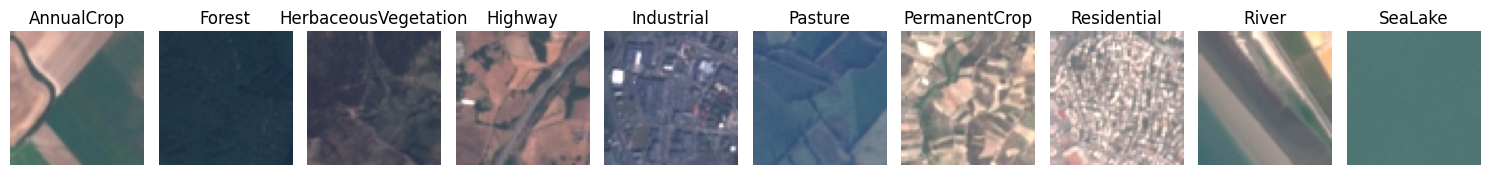

In [17]:
import random

def show_random_sample_per_class(dataset, class_names):
    # Get the number of classes from class_names list
    num_classes = len(class_names)
    
    # Create a figure with specified size for displaying images
    plt.figure(figsize=(15, 5))
    
    # Create a dictionary to store image indices for each class
    class_indices = {class_id: [] for class_id in range(num_classes)}
    
    # Populate the dictionary with image indices for each class
    for idx in range(len(dataset)):
        # Get the label (ignore image data with _)
        _, label = dataset[idx]
        # Add the image index to its corresponding class list
        class_indices[label].append(idx)
    
    # Display one random image from each class
    for class_id, indices in class_indices.items():
        if indices:  # Check if class has any images
            # Select a random index from current class
            random_idx = random.choice(indices)
            
            # Get the image and its label
            img, label = dataset[random_idx]
            
            # Convert tensor dimensions from (C,H,W) to (H,W,C) for matplotlib
            img = img.permute(1, 2, 0).numpy()
            
            # Reverse normalization (if images were normalized)
            img = img * 0.5 + 0.5
            
            # Create subplot for current class
            plt.subplot(1, num_classes, class_id + 1)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_sample_per_class(dataset, class_names)

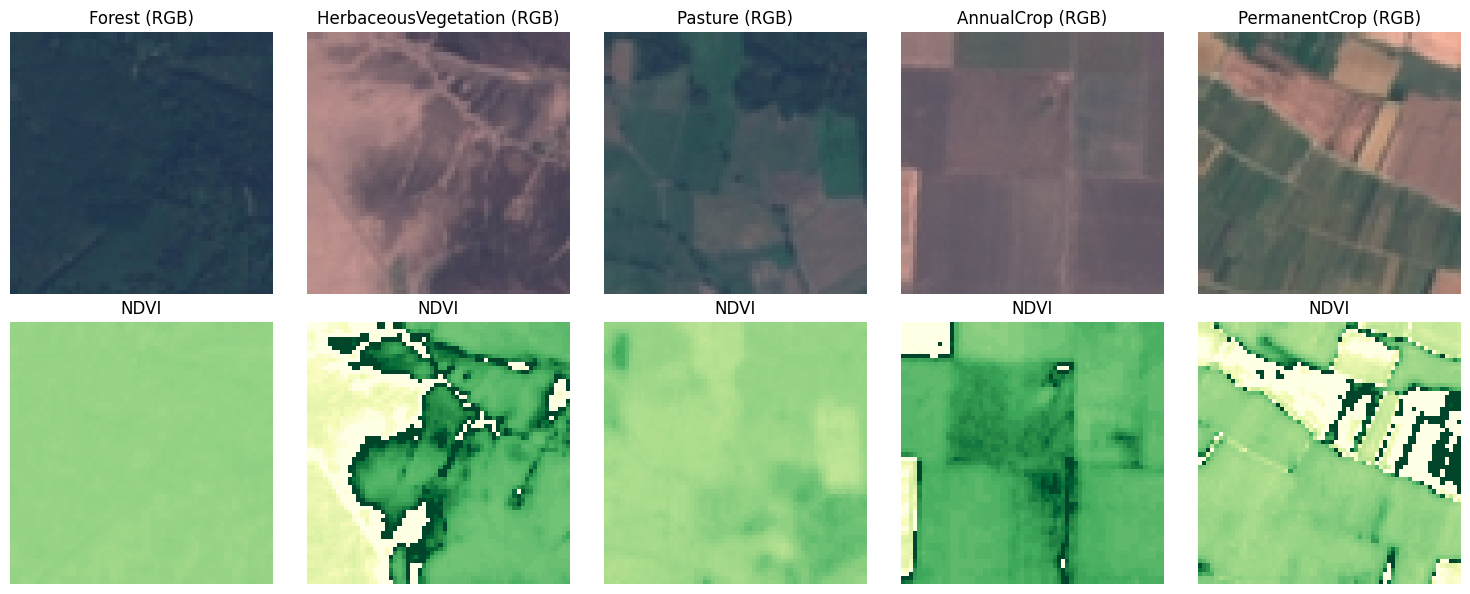

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 🟩 دالة حساب NDVI (محاكاة باستخدام Green بدل NIR)
def calculate_ndvi(images):
    red = images[:, 0, :, :]    # قناة R
    green = images[:, 1, :, :]  # نستخدم Green بدل NIR في EuroSAT RGB
    ndvi = (green - red) / (green + red + 1e-6)
    return ndvi

# 🔄 إزالة التطبيع لعرض الصور بشكل طبيعي
def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    return img_tensor.clamp(0, 1)

# 🖼️ عرض NDVI و RGB باستخدام خريطة ألوان YlGn وضبط التباين
def plot_ndvi_comparison():
    vegetation_classes = ['Forest', 'HerbaceousVegetation', 'Pasture', 'AnnualCrop', 'PermanentCrop']
    plt.figure(figsize=(15, 6))

    for i, class_name in enumerate(vegetation_classes):
        class_idx = full_dataset.class_to_idx[class_name]
        samples = [img for img, label in full_dataset if label == class_idx][:1]

        for img in samples:
            # حساب NDVI
            ndvi = calculate_ndvi(img.unsqueeze(0))[0].cpu().numpy()

            # تجهيز صورة RGB
            rgb = denormalize(img).permute(1, 2, 0).cpu().numpy()
            rgb = np.clip(rgb, 0, 1)

            # عرض RGB
            plt.subplot(2, len(vegetation_classes), i + 1)
            plt.imshow(rgb)
            plt.title(f'{class_name} (RGB)')
            plt.axis('off')

            # عرض NDVI بقيم مثبتة (vmin/vmax) لتجنب الأخضر الزائد
            plt.subplot(2, len(vegetation_classes), len(vegetation_classes) + i + 1)
            plt.imshow(ndvi, cmap='YlGn', vmin=-1, vmax=1)
            plt.title('NDVI')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# تشغيل العرض
plot_ndvi_comparison()


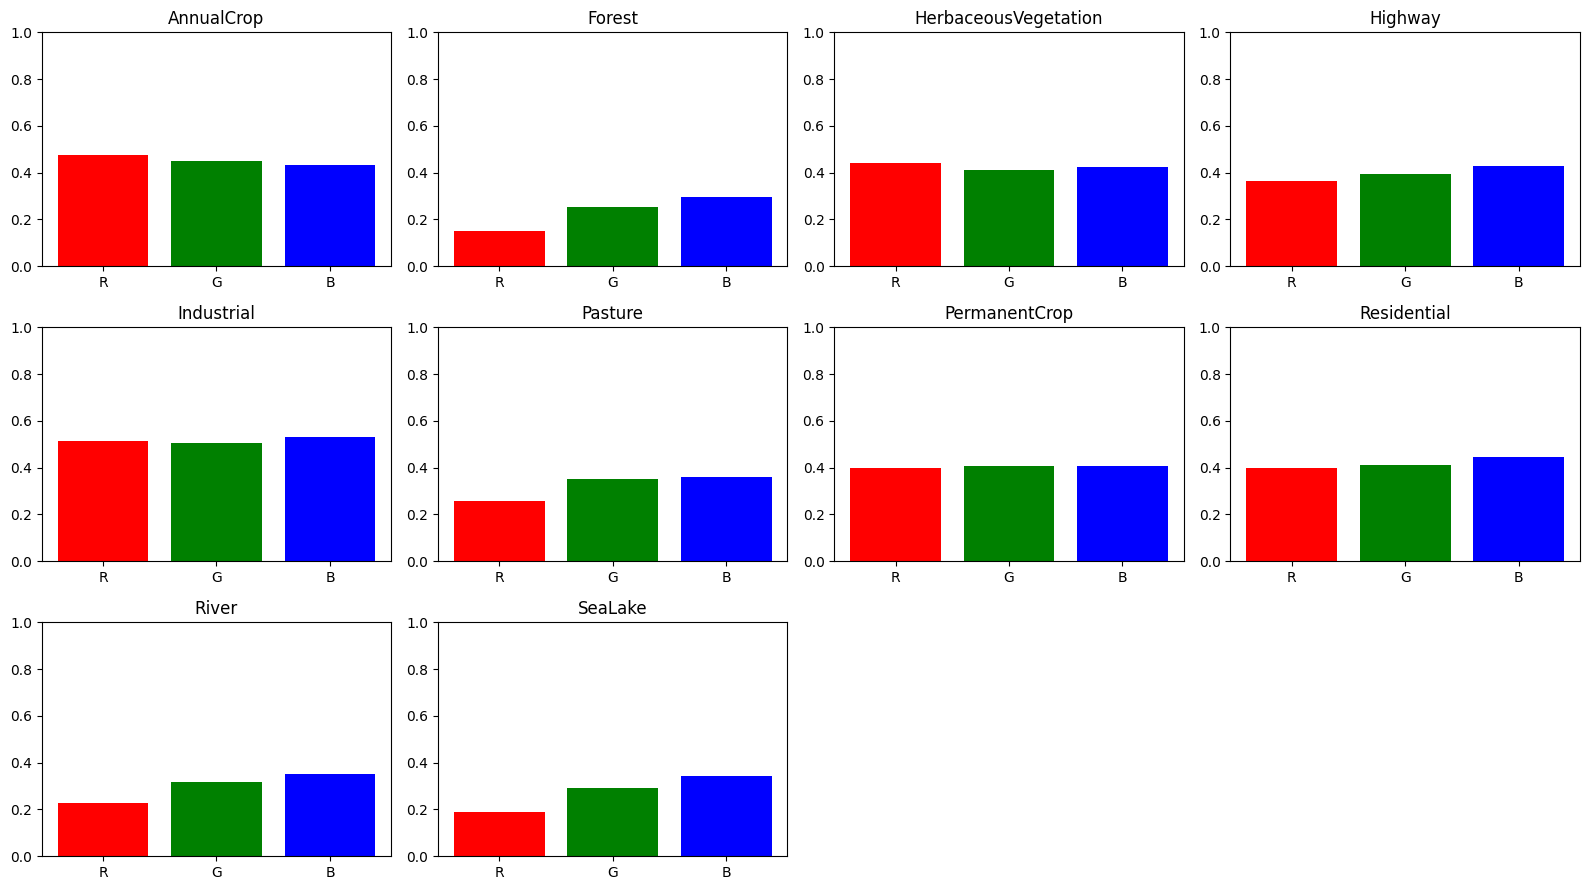

In [7]:
#Create a dictionary to store RGB values for each class
class_rgb = {name: [] for name in class_names}

# Loop through the dataset every 200 samples to reduce computation
for i in range(0, len(full_dataset), 200):
    img, label = full_dataset[i]
    img = img * 0.5 + 0.5  # Unnormalize the image (from [-1,1] to [0,1])
    r, g, b = img[0].mean().item(), img[1].mean().item(), img[2].mean().item()  # Mean values of RGB channels
    class_rgb[class_names[label]].append([r, g, b])  # Store the RGB mean

# Plotting average RGB per class in a single figure using subplots
n_classes = len(class_names)
cols = 4
rows = (n_classes + cols - 1) // cols  # Calculate required rows

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))

# Loop through each class and create a bar plot
for idx, cls in enumerate(class_names):
    row, col = divmod(idx, cols)
    ax = axs[row, col] if rows > 1 else axs[col]  # Support 1-row layout

    rgb_values = np.array(class_rgb[cls])
    mean_rgb = rgb_values.mean(axis=0)

    ax.bar(['R', 'G', 'B'], mean_rgb, color=['red', 'green', 'blue'])
    ax.set_title(cls)
    ax.set_ylim(0, 1)

# Hide empty subplots if any
for idx in range(n_classes, rows * cols):
    row, col = divmod(idx, cols)
    if rows > 1:
        axs[row, col].axis('off')
    else:
        axs[col].axis('off')

plt.tight_layout()
plt.show()


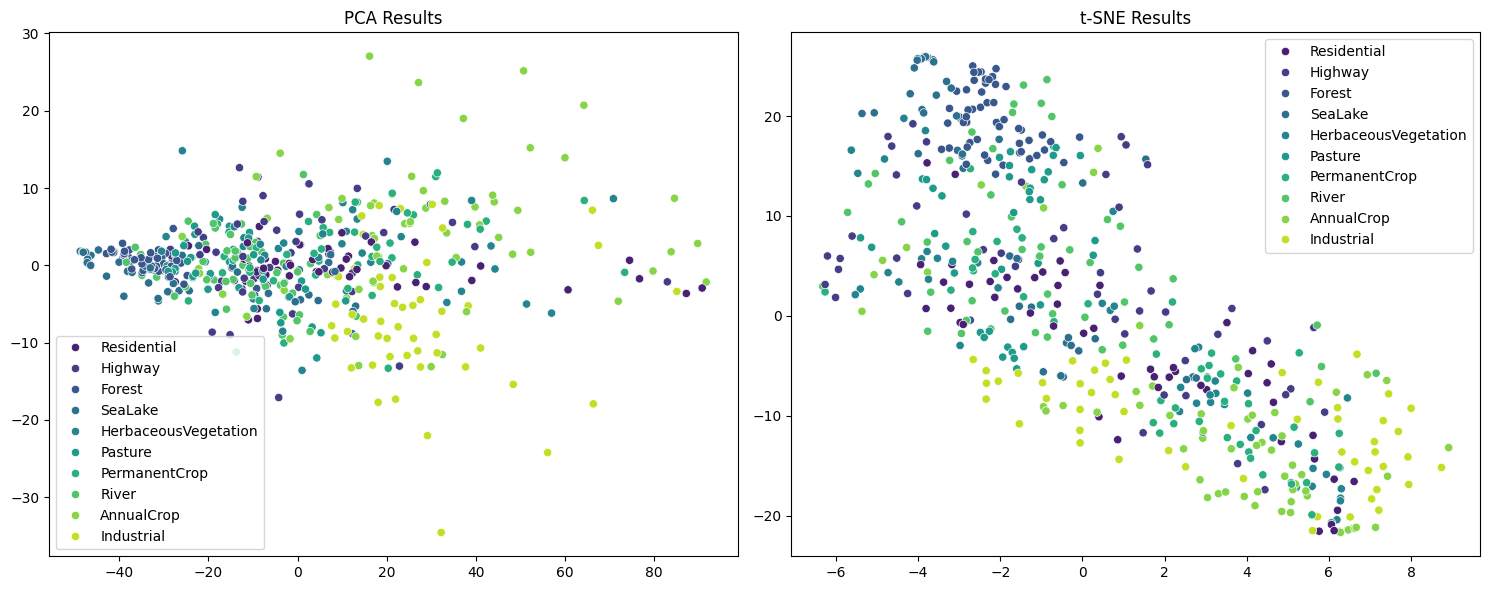

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def apply_dimensionality_reduction(dataset, n_samples=500):
    # أخذ عينة عشوائية
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    images = torch.stack([dataset[i][0] for i in indices]).numpy()
    labels = [dataset[i][1] for i in indices]
    
    # تحويل البيانات إلى 2D باستخدام PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(images.reshape(n_samples, -1))
    
    # تطبيق t-SNE
    tsne = TSNE(n_components=2, perplexity=30)
    tsne_result = tsne.fit_transform(images.reshape(n_samples, -1))
    
    # التصور
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=[full_dataset.classes[i] for i in labels], palette='viridis')
    plt.title('PCA Results')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=[full_dataset.classes[i] for i in labels], palette='viridis')
    plt.title('t-SNE Results')
    
    plt.tight_layout()
    plt.show()

apply_dimensionality_reduction(full_dataset)

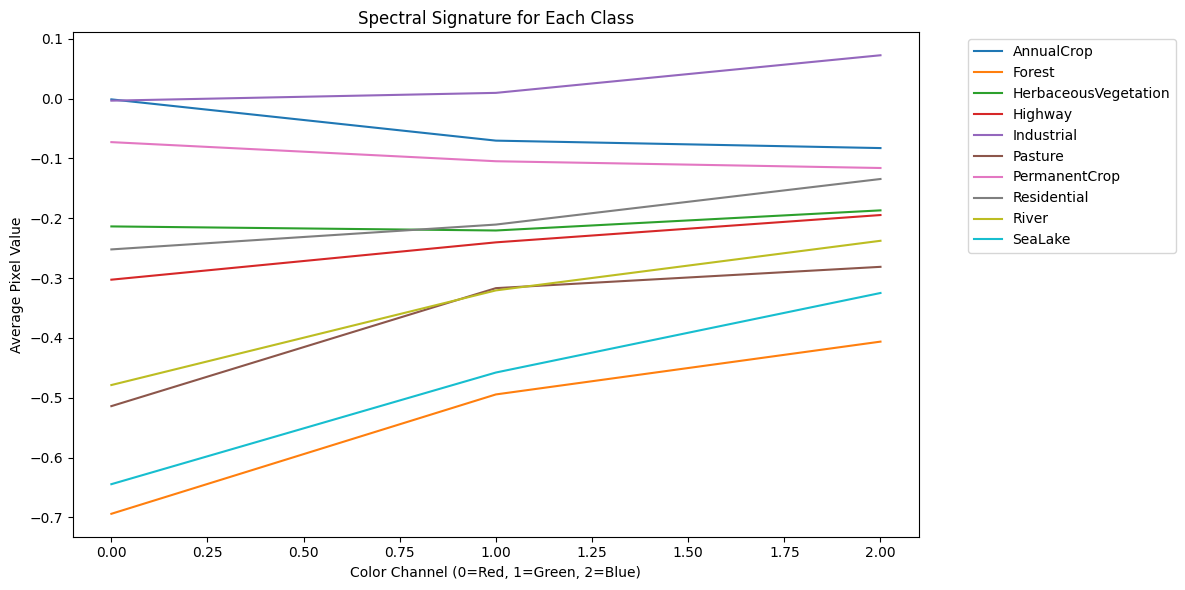

In [ ]:
def plot_spectral_signatures(dataset, n_samples=100):
    # Compute the spectral average for each class
    spectral_means = []
    for class_idx in range(len(dataset.classes)):
        samples = [img for img, label in dataset if label == class_idx][:n_samples]
        class_mean = torch.stack(samples).mean(dim=[0, 2, 3])  # mean per channel
        spectral_means.append(class_mean.numpy())
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for i, (mean, name) in enumerate(zip(spectral_means, dataset.classes)):
        plt.plot(mean, label=name)
    plt.title('Spectral Signature for Each Class')
    plt.xlabel('Color Channel (0=Red, 1=Green, 2=Blue)')
    plt.ylabel('Average Pixel Value')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

plot_spectral_signatures(full_dataset)


In [12]:
from torch.utils.data import DataLoader,random_split
# تقسيم البيانات إلى تدريب واختبار
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# إنشاء DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Szie: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Train Szie: 21600
Test Size: 5400


In [14]:
import torch.nn as nn
from torchvision import models

class EuroSATModel(nn.Module):
    def __init__(self, num_classes=10):
        super(EuroSATModel, self).__init__()
        # تحميل ResNet18 مع أوزان مدربة مسبقاً
        self.resnet = models.resnet18(pretrained=True)
        
        # تجميد جميع الطبقات ما عدا الأخيرة
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # تعديل الطبقة الأخيرة
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# تهيئة النموذج
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EuroSATModel(num_classes=len(class_names)).to(device)
print(model)

C:\Users\Qaiaty store\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Qaiaty store\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EuroSATModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': running_loss/(progress_bar.n+1),
            'acc': 100.*correct/total
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

Training: 100%|██████████| 675/675 [04:20<00:00,  2.59it/s, loss=0.8, acc=74.2]  


Epoch 1/15
Train Loss: 0.8002 | Train Acc: 74.25%
Test Loss: 0.5268 | Test Acc: 82.93%
--------------------------------------------------


Training: 100%|██████████| 675/675 [05:19<00:00,  2.11it/s, loss=0.613, acc=79.9]


Epoch 2/15
Train Loss: 0.6131 | Train Acc: 79.87%
Test Loss: 0.4352 | Test Acc: 85.59%
--------------------------------------------------


Training: 100%|██████████| 675/675 [05:27<00:00,  2.06it/s, loss=0.577, acc=80.9]


Epoch 3/15
Train Loss: 0.5768 | Train Acc: 80.94%
Test Loss: 0.4363 | Test Acc: 85.41%
--------------------------------------------------


Training: 100%|██████████| 675/675 [05:28<00:00,  2.05it/s, loss=0.556, acc=81.6]


Epoch 4/15
Train Loss: 0.5559 | Train Acc: 81.56%
Test Loss: 0.4080 | Test Acc: 86.69%
--------------------------------------------------


Training: 100%|██████████| 675/675 [05:23<00:00,  2.08it/s, loss=0.535, acc=82]  


Epoch 5/15
Train Loss: 0.5347 | Train Acc: 82.00%
Test Loss: 0.4023 | Test Acc: 87.19%
--------------------------------------------------


Training: 100%|██████████| 675/675 [05:44<00:00,  1.96it/s, loss=0.466, acc=84.3]


Epoch 6/15
Train Loss: 0.4662 | Train Acc: 84.33%
Test Loss: 0.3762 | Test Acc: 87.48%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:27<00:00,  2.53it/s, loss=0.442, acc=85.3]


Epoch 7/15
Train Loss: 0.4423 | Train Acc: 85.31%
Test Loss: 0.3820 | Test Acc: 87.33%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:31<00:00,  2.49it/s, loss=0.428, acc=85.7]


Epoch 8/15
Train Loss: 0.4283 | Train Acc: 85.69%
Test Loss: 0.3765 | Test Acc: 87.83%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:31<00:00,  2.48it/s, loss=0.408, acc=86.2]


Epoch 9/15
Train Loss: 0.4081 | Train Acc: 86.16%
Test Loss: 0.3662 | Test Acc: 88.22%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:44<00:00,  2.37it/s, loss=0.404, acc=86.3]


Epoch 10/15
Train Loss: 0.4036 | Train Acc: 86.33%
Test Loss: 0.3646 | Test Acc: 88.24%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:34<00:00,  2.46it/s, loss=0.397, acc=86.5]


Epoch 11/15
Train Loss: 0.3973 | Train Acc: 86.55%
Test Loss: 0.3673 | Test Acc: 87.85%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:38<00:00,  2.43it/s, loss=0.397, acc=86.6]


Epoch 12/15
Train Loss: 0.3967 | Train Acc: 86.57%
Test Loss: 0.3655 | Test Acc: 88.06%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:31<00:00,  2.48it/s, loss=0.393, acc=86.8]


Epoch 13/15
Train Loss: 0.3928 | Train Acc: 86.84%
Test Loss: 0.3644 | Test Acc: 88.35%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:37<00:00,  2.44it/s, loss=0.397, acc=86.5]


Epoch 14/15
Train Loss: 0.3971 | Train Acc: 86.46%
Test Loss: 0.3700 | Test Acc: 88.09%
--------------------------------------------------


Training: 100%|██████████| 675/675 [04:55<00:00,  2.28it/s, loss=0.395, acc=86.8]


Epoch 15/15
Train Loss: 0.3945 | Train Acc: 86.75%
Test Loss: 0.3646 | Test Acc: 87.93%
--------------------------------------------------


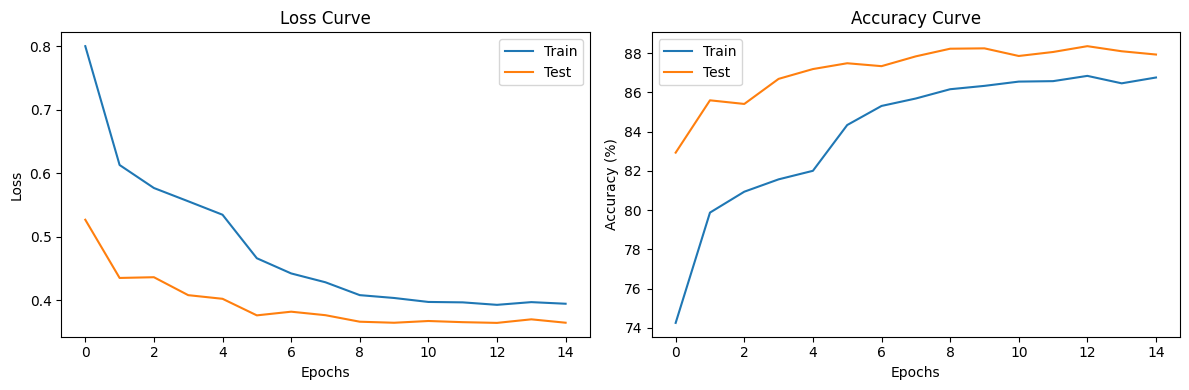

In [17]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# متغيرات لتخزين النتائج
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# التدريب
num_epochs = 15
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    print('-' * 50)

# رسم منحنيات الأداء
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

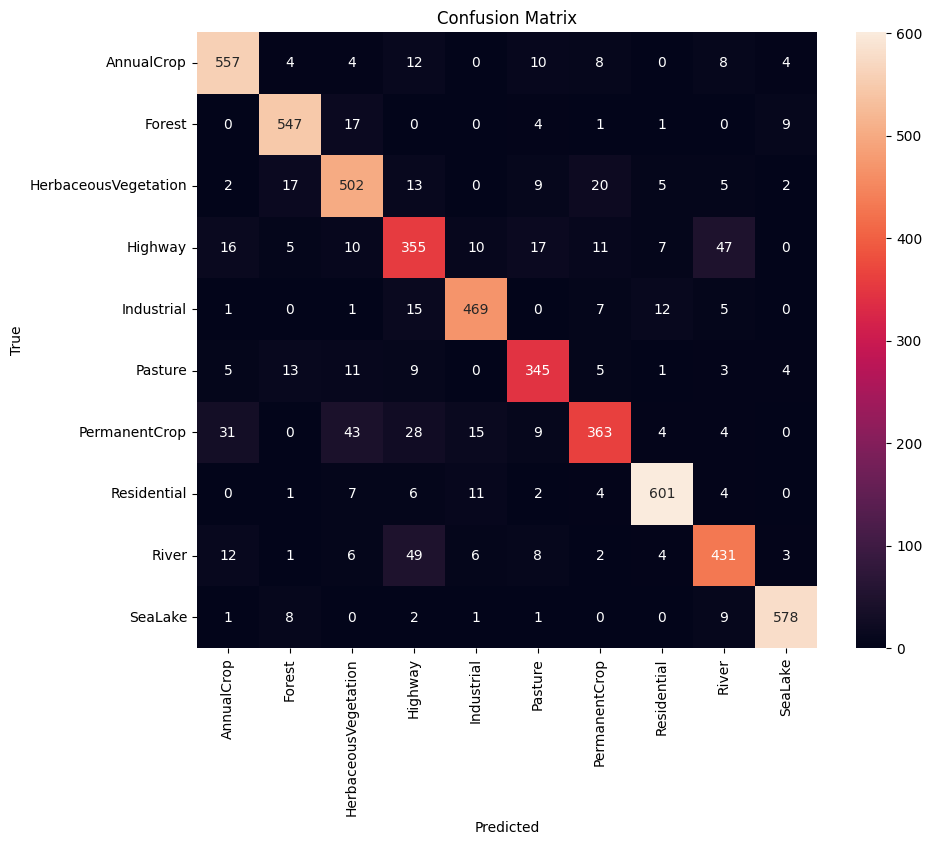

                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.92      0.90       607
              Forest       0.92      0.94      0.93       579
HerbaceousVegetation       0.84      0.87      0.85       575
             Highway       0.73      0.74      0.73       478
          Industrial       0.92      0.92      0.92       510
             Pasture       0.85      0.87      0.86       396
       PermanentCrop       0.86      0.73      0.79       497
         Residential       0.95      0.94      0.95       636
               River       0.84      0.83      0.83       522
             SeaLake       0.96      0.96      0.96       600

            accuracy                           0.88      5400
           macro avg       0.87      0.87      0.87      5400
        weighted avg       0.88      0.88      0.88      5400



In [18]:
from sklearn.metrics import confusion_matrix,classification_report

# تقييم النموذج على بيانات الاختبار
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)

# مصفوفة الارتباك
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# تقرير التصنيف
print(classification_report(all_labels, all_preds, target_names=class_names))

In [19]:
torch.save(model.state_dict(), 'eurosat_resnet18.pth')